# Helper functions

In [1]:
%load_ext autoreload
%autoreload 2

import re
import pandas as pd
import json
from SynFlow.SCD import print_jsd_by_period, plot_jsd_by_period, plot_items_jsd_by_period

In [2]:
# Replace in file(s)

def replace_in_file(file_path, replacements):
    """
    Replace strings in a single file.

    Parameters:
    - file_path (str): Path to the file to process.
    - replacements (dict): Dictionary of replacements, e.g., {"old_term": "new_term"}
    """
    with open(file_path, 'r', encoding='utf-8') as f:
        content = f.read()

    for old, new in replacements.items():
        content = content.replace(old, new)

    with open(file_path, 'w', encoding='utf-8') as f:
        f.write(content)

    print(f"✓ Done: {file_path}")

import os

def replace_in_folder(folder, replacements, file_suffix=None):
    """
    Apply `replace_in_file` to all files in a folder.

    Parameters:
    - folder (str): Path to the folder.
    - replacements (dict): Dictionary of replacements.
    - file_suffix (str): Only process files ending with this suffix (optional).
    """
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)

        if not os.path.isfile(file_path):
            continue
        if file_suffix and not filename.endswith(file_suffix):
            continue

        replace_in_file(file_path, replacements)


# Merge into multi-word phrase

In [ ]:
def merge_phrases(head_lemma, dep_lemma, file_path):
    pattern = re.compile(
        r'^([^\t]+)\t'      # wordform
        r'([^\t]+)\t'       # lemma
        r'([^\t]+)\t'       # POS
        r'([^\t]+)\t'       # ID
        r'([^\t]+)\t'       # HEAD
        r'([^\t]+)$'        # DEPREL
    )

    with open(file_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()

    new_lines = []
    sentence = []
    in_sentence = False

    for line in lines:
        stripped = line.strip()
        if stripped.startswith('<s id='):
            sentence = [line]
            in_sentence = True
        elif stripped.startswith('</s>'):
            sentence.append(line)

            # Tách các dòng chứa token
            tokens = [l.strip() for l in sentence if pattern.match(l)] # Get the line with the tokens
            parsed = [pattern.match(l).groups() for l in tokens] # A list of tuples of individual tokens
            # print(parsed)
            id2token = {fields[3]: list(fields) for fields in parsed}  # A dictonary idx: [wordform, lemma, pos, id, head, deprel]
            # print(id2token)
            merged_heads = set() # Avoid merging multiple times with one head

            for fields in parsed:
                wordform, lemma, pos, idx, head, deprel = fields # Tuple unpacking
                # Nếu đúng là dep lemma, và head tồn tại
                if lemma == dep_lemma and head in id2token:
                    print(head)
                    head_fields = id2token[head]
                    print(head_fields)
                    head_wordform, head_lemma_ = head_fields[0], head_fields[1],
                    if head_lemma_.lower() == head_lemma.lower() and head not in merged_heads:
                        # Gộp lại
                        merged_lemma = f"{dep_lemma}_{head_lemma_}"
                        merged_token = f"{dep_lemma}_{head_wordform}"
                        id2token[head][0] = merged_token
                        id2token[head][1] = merged_lemma
                        merged_heads.add(head)

            # Ghi lại câu đã cập nhật
            updated_sentence = []
            for l in sentence:
                m = pattern.match(l.strip())
                if not m:
                    updated_sentence.append(l)
                    continue
                wordform, lemma, pos, idx, head, deprel = m.groups()
                if idx in id2token:
                    wordform, lemma, _, _, _, _ = id2token[idx]
                updated_sentence.append(f"{wordform}\t{lemma}\t{pos}\t{idx}\t{head}\t{deprel}\n")
            new_lines.extend(updated_sentence)
            in_sentence = False
        elif in_sentence:
            sentence.append(line)
        else:
            new_lines.append(line)

    with open(file_path, 'w', encoding='utf-8') as f:
        f.writelines(new_lines)


In [ ]:
for file in os.listdir("/home/volt/bach/pilot_data/RSC/1750-1800-che"):
    file_path = "/home/volt/bach/pilot_data/RSC/1750-1800-che/" + file
    print(file_path)
    merge_phrases(head_lemma="air", dep_lemma="dephlogisticate", file_path=file_path)

# Merged Phrases:
# phlogisticated air
# dephlogisticated air

In [ ]:
folder = "/home/volt/bach/pilot_data/RSC/1750-1800_che"

for file in os.listdir(folder):
    file_path = os.path.join(folder, file)

    # Đảm bảo là file văn bản, nếu cần
    if not os.path.isfile(file_path):
        continue

    with open(file_path, 'r', encoding='utf-8') as f:
        content = f.read()

    # Thay thế các cụm từ
    content = content.replace("phlogisticated_air", "air")

    # Ghi đè lại
    with open(file_path, 'w', encoding='utf-8') as f:
        f.write(content)

    print(f"✓ Done: {file_path}")

# Analysis

## All slot

1. Plot the distribution of argument slots in each period.
2. Compute JSD on the distribution of slots

In [ ]:
corpus_path = '/home/volt/bach/pilot_data/RSC/1750-1799_che_half_decades'
keyword_string = 'air\tNOUN'
fname_pattern = re.compile(
    r'Royal_Society_Corpus_open_v6\.0_text_(?P<id>\d+)_(?P<year>\d+)\.txt$'
)

### Frequency changes

In [ ]:
from SynFlow.SCD.freq import count_keyword_tokens_by_period
token_counts = count_keyword_tokens_by_period(corpus_path, keyword_string, fname_pattern=fname_pattern, mode='half_decade')
print(token_counts)

In [ ]:
from SynFlow.SCD.freq import plot_freq_top_union_slots_by_period
slot_json_path = "/home/volt/bach/SynFlow/output/air-N-1750-1799/Explorer/air_N_arguments.json"

# plot_freq_top_union_slots_by_period(
#     json_path=json_path,
#     top_n=7,
#     normalized=False,
#     token_counts=token_counts,
#     chart_type="line"
# )

plot_freq_top_union_slots_by_period(
    json_path=slot_json_path,
    top_n=7,
    normalized=True,
    token_counts=token_counts,
    chart_type="line"
)


In [ ]:
def slot_change_scores(json_path, token_counts):
    '''
    Return the ranking of the top changing slots across periods

    Parameters:
        json_path (str): Path to JSON with slot counts per period.
        token_counts (dict): {period: token count} for normalisation
    
    Returns:
        dict: {slot: change_score}
    '''
    # Read json file
    with open(json_path, "r") as f:
        data = json.load(f)

    # Load into DataFrame
    df = pd.DataFrame.from_dict(data, orient="index").fillna(0).astype(float)

    # # Normalised by the number of token counts in that period
    if token_counts is None:
        raise ValueError("token_counts must be provided when normalized=True")
    token_counts_str = {str(k).replace("_", "-"): v for k, v in token_counts.items()}

    missing = set(df.index) - set(token_counts_str.keys())
    if missing:
        raise ValueError(f"Missing document counts for: {missing}")
    for period in df.index:
        df.loc[period] /= token_counts_str[period]

    # Take row n and subtract row n-1 and convert into positive
    df_diff = df.diff(axis=0).fillna(0).abs()

    # Culmulative Change
    # Sum over all rows and sort
    df_diff_sum = df_diff.sum(axis=0).sort_values(ascending=False)

    # Max single-period change
    max_change = df_diff.max(axis=0).sort_values(ascending=False)

    # Compute range (max - min) over all periods
    df_range = (df.max(axis=0) - df.min(axis=0)).sort_values(ascending=False)

    # Standard deviation
    std_change = df.std(axis=0).sort_values(ascending=False)

    return df_diff_sum, max_change, df_range, std_change

In [ ]:
df_diff_sum, max_change, df_range, std_change = slot_change_scores(json_path=slot_json_path, token_counts=token_counts)
print('df_diff_sum:', df_diff_sum)
print('-' * 100)
print('max_change:', max_change)
print('-' * 100)
print('df_range', df_range)
print('-' * 100)
print('std_change', std_change)

### Slots JSD

In [ ]:
from SynFlow.SCD.jsd import slots_jsd_by_period
slots_js_results = slots_jsd_by_period(
    json_path=slot_json_path,
    top_n=10,
    min_count=0
)

print_jsd_by_period(slots_js_results)

In [ ]:
plot_jsd_by_period(slots_js_results)

In [ ]:
plot_items_jsd_by_period(slots_js_results, top_n=7, cols=3)

## One specific slot

### Adjective and Determiner of air
1. See the shift in the distribution of the adjective that comes with air
2. Merge phlogisticated and dephlogisticated with air
    * See the shift in the distribution of phlogistcated air and dephlogisticated air
    * Compare that with the distribution of oxygen and nitrogen

In [3]:
fname_df_pattern = re.compile(
    rf'air/Royal_Society_Corpus_open_v6\.0_text_'   # fixed prefix
    rf'(?P<id>\d+)_'                            # capture numeric ID
    rf'(?P<year>\d+)'                           # capture year
    rf'.txt/\d+$'             #  and extension and line number
)

#### Preprocessing

This step is unique to the type of data we're working with. Make sure that the time column is in integer.

In [4]:
# Process the adjective dataframe
def process_air_slot_csv(slot_type, input_path, output_path):
    """
    Process a CSV file to:
    - Unpack list values in 'chi_amod' column into separate rows
    - Extract year from 'id' column using regex
    - Compute 'decade' (e.g. 1750, 1760) and 'half_decade' (e.g. 1750–1754, 1755–1759)
    - Only keep rows from 1750–1799
    - Write the cleaned result to a new CSV
    """

    # Read CSV
    df = pd.read_csv(input_path)

    # Ensure slot_type is a list (assumes it's stored as a string representation)
    df[slot_type] = df[slot_type].apply(eval)

    # Explode lists into separate rows
    df = df.explode(slot_type).reset_index(drop=True)

    # Compile regex to extract year
    pattern = re.compile(
        r'air/Royal_Society_Corpus_open_v6\.0_text_'
        r'(?P<id>\d+)_'
        r'(?P<year>\d+)\.txt/\d+$'
    )

    # Extract year, decade, half-decade
    def extract_time_info(id_string):
        match = pattern.match(id_string)
        if match:
            year = int(match.group("year"))
            if 1750 <= year < 1800:
                decade = year - (year % 10)
                half = f"{year - (year % 5)}–{year - (year % 5) + 4}"
                return pd.Series([year, decade, half])
        return pd.Series([None, None, None])

    df[["year", "decade", "half_decade"]] = df["id"].apply(extract_time_info)
    # Extract start year from half_decade
    df["half_decade"] = df["half_decade"].str.extract(r"(\d{4})").astype(float).astype("Int64")


    # Drop rows outside 1750–1799
    df = df[df["decade"].notnull()]

    # Save cleaned file
    df.to_csv(output_path, index=False)

In [7]:
air_adj_df = '/home/volt/bach/SynFlow/input/SCD/air_adj_1750-1799.csv' 
air_det_df = '/home/volt/bach/SynFlow/input/SCD/air_det_1750-1799.csv'
air_case_df = '/home/volt/bach/SynFlow/input/SCD/air_case_1750-1799.csv'
air_nmod_df = '/home/volt/bach/SynFlow/input/SCD/air_nmod_1750-1799.csv'

process_air_slot_csv('chi_amod', 
                     '/home/volt/bach/SynFlow/output/air-N-1750-1799/Embedding/air_samples_slotdf_all.csv',
                     air_nmod_df)

In [8]:
# Replace the V/A and some misspellings
replacements = {
    "dephlogisticate/V": "dephlogisticated/A",
    "phlogisticate/V": "phlogisticated/A",
    'plllogisticate/V': 'phlogisticated/A',
    'deplllogisticate/V': 'dephlogisticated/A',
    'gisticate/V': 'phlogisticated/A',
    'Open/A': 'open/A',
}

replace_in_file(
    file_path=air_adj_df,
    replacements=replacements
    )

✓ Done: /home/volt/bach/SynFlow/input/SCD/air_adj_1750-1799.csv


#### Frequency Changes

In [9]:
from SynFlow.SCD.freq import plot_freq_top_union_sfillers_by_period

In [10]:
# Bar chart (absolute freq)
plot_freq_top_union_sfillers_by_period(air_adj_df, 
                              slot_type='chi_amod',
                              top_n=10,
                              normalized=True, # Normalised or Raw count
                              time_col='half_decade',
                              chart_type='line' # either line or bar
                              )



#### Slot Filler JSD

In [11]:
from SynFlow.SCD.jsd import sfillers_jsd_by_period

In [12]:
sfillers_js_df = pd.read_csv(air_adj_df)
sfillers_js_results = sfillers_jsd_by_period(sfillers_js_df, word_col='chi_amod', period_col='half_decade')
print_jsd_by_period(sfillers_js_results)


=== Shift to period 1755 ===
Jensen-Shannon Divergence: 0.5817
Top shifted items:
  de_open/A: 0.1200
  in_fresh/A: 0.0479
  de_dry/A: 0.0294
  in_incumbent/A: 0.0205
  in_subjacent/A: 0.0205
  in_common/A: 0.0205
  de_pure/A: 0.0196
  in_whole/A: 0.0137
  in_hot/A: 0.0137
  in_low/A: 0.0137

=== Shift to period 1760 ===
Jensen-Shannon Divergence: 0.5762
Top shifted items:
  de_fresh/A: 0.0479
  in_surround/V: 0.0385
  in_moist/A: 0.0385
  in_open/A: 0.0381
  in_hot/A: 0.0210
  de_incumbent/A: 0.0205
  de_subjacent/A: 0.0205
  de_common/A: 0.0205
  in_outward/A: 0.0192
  in_vaporous/A: 0.0192

=== Shift to period 1765 ===
Jensen-Shannon Divergence: 0.7917
Top shifted items:
  in_fix/V: 0.1603
  de_open/A: 0.1271
  in_common/A: 0.0870
  in_inflammable/A: 0.0605
  de_hot/A: 0.0511
  de_surround/V: 0.0385
  de_moist/A: 0.0325
  de_rarefied/A: 0.0286
  in_much/A: 0.0234
  de_heat/V: 0.0192

=== Shift to period 1770 ===
Jensen-Shannon Divergence: 0.2665
Top shifted items:
  in_nitrous/A: 0

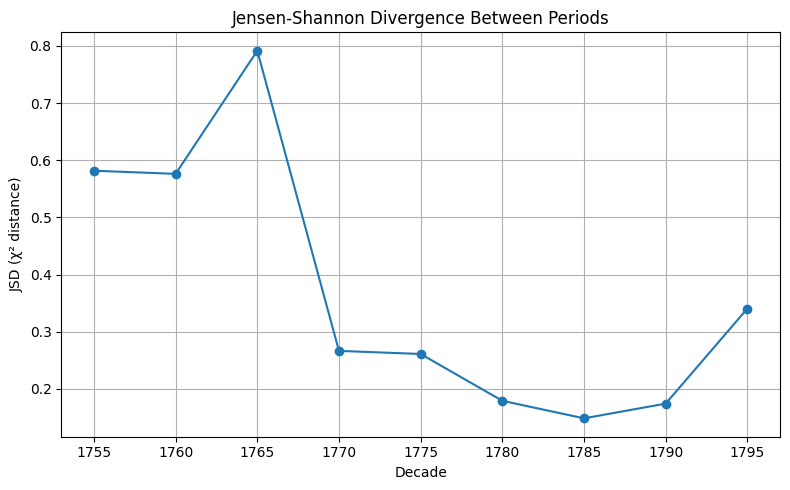

In [13]:
plot_jsd_by_period(sfillers_js_results)

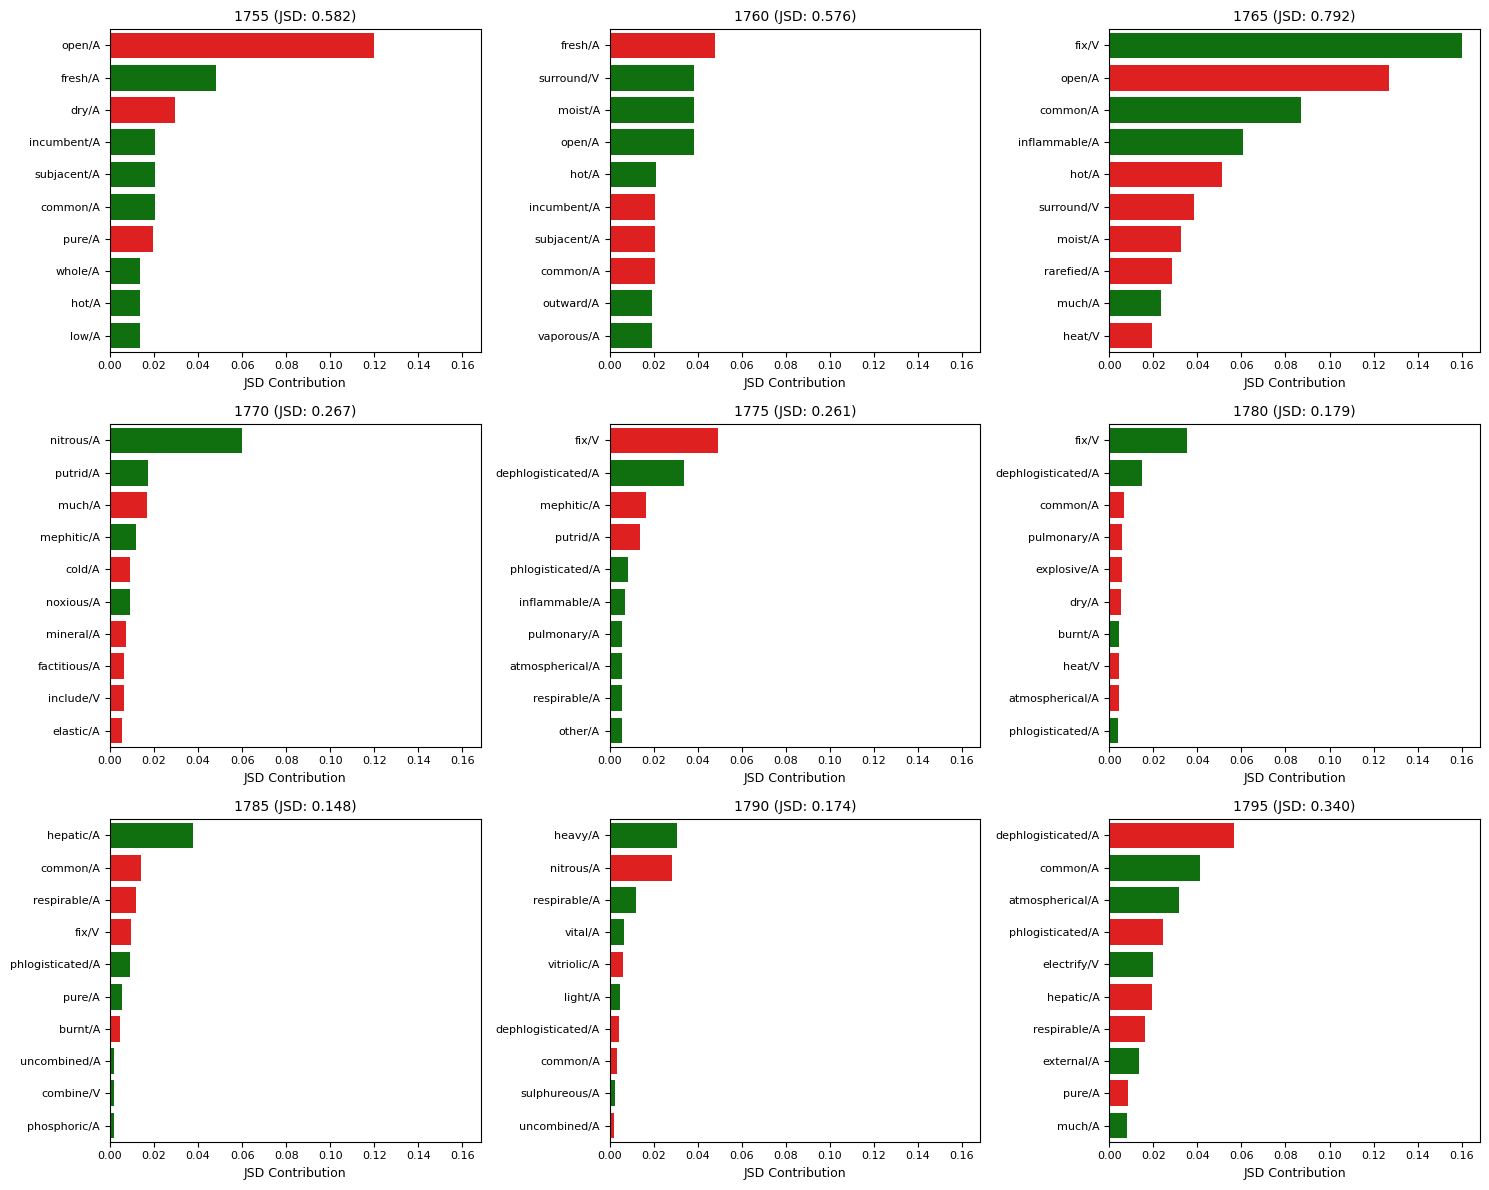

In [14]:
plot_items_jsd_by_period(sfillers_js_results, top_n=10, cols=3)